<a href="https://colab.research.google.com/github/smmurdock/Neural-Network-Sentiment-Analysis/blob/main/d604_task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# D604 Task 2 - Sentiment Analysis Using Neural Networks

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/1 Projects/_WGU | MS-DataAnalytics-DataScience/WGU | D604 - ADVANCED ANALYTICS/Task 2 - Sentiment Analysis Using Neural Networks

/content/drive/MyDrive/1 Projects/_WGU | MS-DataAnalytics-DataScience/WGU | D604 - ADVANCED ANALYTICS/Task 2 - Sentiment Analysis Using Neural Networks


## A. Research Purpose

> Describe the purpose of this data analysis by doing the following:

### A1. Research Question

> Summarize one research question that you will answer using a neural network model and NLP techniques. Be sure the research question is relevant to a real-world organizational situation and sentiment analysis captured in your chosen dataset or datasets.


  Note: If you choose to use more than one dataset, you must concatenate them into one dataset for parts II and III.

**Research Question:** Can a neural network be trained to accurately classify sentiment in customer product reviews from Amazon as either positive or negative?

This question is directly relevant to a real-world organizational situation. For a company like Amazon or any third-party seller on its platform, manually sifting through thousands of customer reviews to gauge public opinion is impractical based on the sheer volume of Amazon's product catalog. A system that can accurately classify sentiment allows an organization to quickly monitor customer feedback at scale. This enables them to identify popular product features, detect widespread product defects, determine if a product is likely to be returned, and track shifts in customer satisfaction over time, leading to faster product improvements and better customer service.

### A2. Objectives or Goals

> Define the objectives or goals of the data analysis. Be sure each objective or goal is reasonable within the scope of the research question and is represented in the available data.

The primary goals of this data analysis are to design, build, and evaluate a neural network for sentiment classification. The specific objectives are as follows:

* **Data Preprocessing:** To clean and prepare the raw text data from the Amazon reviews dataset for modeling.

* **Model Development:** To build and train a suitable neural network. This analysis will use an LSTM-based architecture, which is effective for learning from sequential data like text. The goal is to train the model to recognize patterns and contextual cues in word usage that indicate positive or negative sentiment.

* **Model Evaluation:** To assess the performance of the trained model on an unseen test dataset. The objective is to quantify its predictive accuracy using key classification metrics. This evaluation will directly answer how effectively the model can classify new, unseen review data.

### A3. Prescribed Network

> Identify an industry-relevant type of neural network capable of performing a text classification task that can be trained to produce useful predictions on text sequences on the selected dataset.

An appropriate and industry-relevant neural network for this text sentiment classification tasks is the **Long Short-Term Memory (LSTM)** neural network.

LSTMs are a type of **Recurrent Neural Network (RNN)** specifically designed to handle and learn from sequential data like text, where the order of text matters. Unlike standard RNNs, LSTMs have internal memory cells that can maintain information over long sequences (Audevart et al., 2021, p. 272). This capability is crucial for natural language processing because the meaning of a word often depends on its context (Ahmad, 2023, p. 333). An LSTM can capture these dependencies, allowing it to understand nuances in language that are critical for accurately determining sentiment. This makes LSTMs a powerful and widely used tool for sentiment analysis in real-world applications.

## B. Data Preparation

> Summarize the data cleaning process by doing the following:

### B1. Data Exploration

> Perform exploratory data analysis on the chosen dataset, and include an explanation of each of the following elements:

  * presence of unusual characters (e.g., emojis, non-English characters)
  * vocabulary size
  * word embedding length
  * statistical justification for the chosen maximum sequence length

In [3]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Format for readability
pd.set_option('display.max_colwidth', 100)
sns.set_style('whitegrid')

# Load the data
df = pd.read_csv('amazon_cells_labelled.txt',
                 sep='\t',
                 header=None,
                 names=['review', 'sentiment'])

# View the first few rows
print("First 5 rows:")
df.head()

First 5 rows:


,review,sentiment
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1


The code cell above loads in the basic libraries needed to get started.

The code loads in the text file as a tab-deliminted file with no headers indentifying what the observations mean. Because of this, I looked at the data ahead of time in its raw format and determined appropriate names to act as column headers.

Then, the code reads the first five rows and gives a glimpse of how the data is formatted and what issues may present themselves. We can already seem some issues like use of punctuation, differences in casing, and missing spaces in between sentences.

In [4]:
# Basic dataset information
print(f"Dataset shape: {df.shape}")
print("=" * 60)
print(f"Total reviews: {df.shape[0]}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicates: {df.duplicated().sum()} ({df.duplicated().sum() / len(df) * 100:.1f}%)")

Dataset shape: (1000, 2)
Total reviews: 1000
Missing values: 0
Duplicates: 10 (1.0%)


The dataset contains 1,000 Amazon product reviews with no missing values. There are 10 duplicate reviews (1% of the dataset), which we'll remove to ensure data quality.

In [5]:
# Remove duplicates
df_clean = df.drop_duplicates(keep='first')
print(f"Shape after removing duplicates: {len(df_clean)} reviews")

Shape after removing duplicates: 990 reviews


The code above removes the duplicate reviews, keeping the first instance of any duplicates, and then shows a count of how many reviews remain.

In [6]:
# Check unique values in sentiment column
print("Unique sentiment values:")
print(df_clean['sentiment'].unique())
print(f"Number of unique sentiment values: {df_clean['sentiment'].nunique()}")

Unique sentiment values:
[0 1]
Number of unique sentiment values: 2


The code cell above checks the DataFrame's `'sentiment'` column for unique values to ensure that there are only the expected binary values of `0` for negative sentiment and `1` for positive sentiment. There are no unexpected values.

In [7]:
# Check class balance
print("Sentiment distribution:")
print(df_clean['sentiment'].value_counts())
print(f"\nPercentages:")
print(df_clean['sentiment'].value_counts(normalize=True) * 100)

Sentiment distribution:
sentiment
0    497
1    493
Name: count, dtype: int64

Percentages:
sentiment
0    50.20202
1    49.79798
Name: proportion, dtype: float64


The code cell above checks how balanced the sentiment is across negative and positive reviews, both in actual numbers and in proportion to the full remaining dataset.

After removing the duplicates, there are 497 negative reviews and 493 positive reviews. Based on the small difference, we can consider this dataset to be balanced.

This information is important to keep in mind for when we split our datasets into train/validation/test datasets later in step **B5. Steps to Prepare the Data**, as we'll want to keep the proportions while shuffling the data. This ensures that the model *can't* learn from patterns that occur based on what order the data was added to the dataset but that it *can* learn, validate, and test fairly across representative proportions.

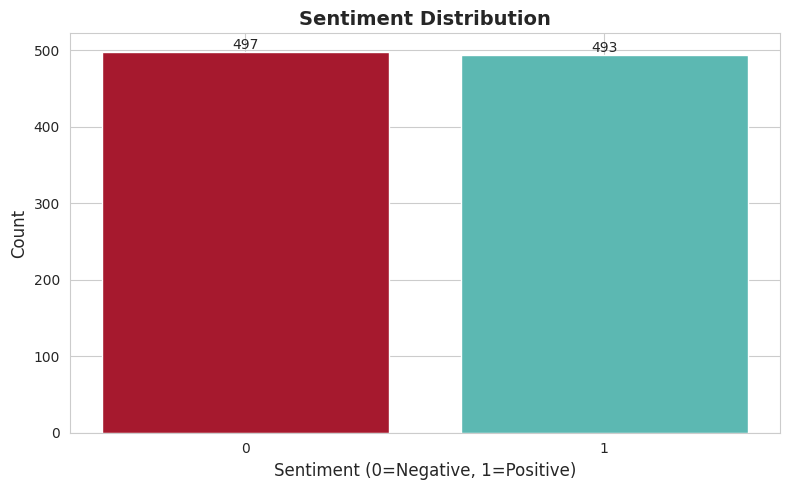

In [8]:
# Visualize class balance
plt.figure(figsize=(8, 5))
sentiment_counts = df_clean['sentiment'].value_counts()
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=['#A6192E', '#5CB8B2'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.title('Sentiment Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment (0=Negative, 1=Positive)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

The code cell above visualizes the class balance of negative and positive sentiment observations for the full cleaned dataset. The exact values are added above each bar because they are nearly indecipherable at a visual glance.

#### Presence of unusual characters

**Analyze Unusual Characters Before Cleaning**

Working definition of unusual characters: Any emojis, non-English characters, non-Unicode characters, punctuation, or control characters

In [9]:
import re
import string
from collections import Counter

# Convert to lowercase
df_clean['review_lower'] = df_clean['review'].str.lower()

# Check for unusual characters
all_text = ' '.join(df_clean['review_lower'])
char_frequency = Counter(all_text)

# Categorize characters
letters = set(string.ascii_lowercase)
digits = set(string.digits)
punctuation = set(string.punctuation)
whitespace = set(string.whitespace)

unusual_chars = {char: count for char, count in char_frequency.items()
                 if char not in letters and char not in digits
                 and char not in punctuation and char not in whitespace}

print("Unusual characters found:", unusual_chars if unusual_chars else "None")
print(f"\nTotal punctuation marks: {sum(count for char, count in char_frequency.items() if char in punctuation)}")

Unusual characters found: None

Total punctuation marks: 1908


The code cell above works to determine all unique characters in the `review` data. It starts by converting all text to lowercase to avoid considering text like "a" and "A" or "good" and "Good" as different characters/words.

Next, it joins all text into one long string to pass into the `Counter()` method which returns a dictionary-like object with a frequency count representing how many times each character is present in the string.

Then we use built-in `string` methods to define the characters we are looking for, and checks for any unusual characters in the dataset. There are no unusual characters found in this dataset. The dataset only contains standard English letters, digits, punctuation, and whitespace.

In [10]:
# Clean text: remove punctuation and digits
punctuation_pattern = '[' + re.escape(string.punctuation) + ']+'
df_clean['review_clean'] = df_clean['review_lower'].str.replace(punctuation_pattern, ' ', regex=True)
df_clean['review_clean'] = df_clean['review_clean'].str.replace(r'\d+', '', regex=True)
df_clean['review_clean'] = df_clean['review_clean'].str.split().str.join(' ')

# Create final clean dataset
df = df_clean[['review_clean', 'sentiment']].copy()
df.rename(columns={'review_clean': 'review'}, inplace=True)

print("Sample cleaned reviews:")
df.head()

Sample cleaned reviews:


,review,sentiment
0,so there is no way for me to plug it in here in the us unless i go by a converter,0
1,good case excellent value,1
2,great for the jawbone,1
3,tied to charger for conversations lasting more than minutes major problems,0
4,the mic is great,1


This code cleans the text by removing punctuation and digits from the text, using a combination of string methods and regular expressions. This is a standard preprocessing step that helps normalize the text.

#### Vocabulary size

In [11]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab', quiet=True)

# Tokenize all reviews
all_reviews = df['review'].tolist()
all_tokens = []
for review in all_reviews:
    tokens = word_tokenize(review)
    all_tokens.extend(tokens)

# Calculate vocabulary size
vocabulary_size = len(set(all_tokens))
total_words = len(all_tokens)

print(f"Total words (with duplicates): {total_words:,}")
print(f"Vocabulary size (unique words): {vocabulary_size:,}")

Total words (with duplicates): 10,339
Vocabulary size (unique words): 1,816


This code tokenizes each review, converting all words into a token, which can be read by a machine learning model. Words in text form cannot be read by machine learning models. Within the dataset, there are 10,339 total words/tokens including duplicates. We have a vocabulary size of 1,816 when counting only unique instances of a word.

In [12]:
# Reveal top 20 most common words based on frequency
word_freq = Counter(all_tokens)
top_20 = word_freq.most_common(20)

print("Top 20 Most Frequent Words:")
for word, freq in top_20:
    print(f"{word}: {freq}")


Top 20 Most Frequent Words:
the: 518
i: 379
it: 311
and: 311
is: 241
a: 217
this: 205
to: 196
phone: 164
my: 145
not: 121
of: 120
for: 119
with: 112
very: 104
great: 93
was: 90
on: 90
in: 88
that: 82


The vocabulary contains 1,812 unique words. The most frequently occuring words include "the," 'i," "it," "and," "is," and "a," which are all typical in the English language. I am choosing not to remove stop words because the vocabulary size is already quite small.

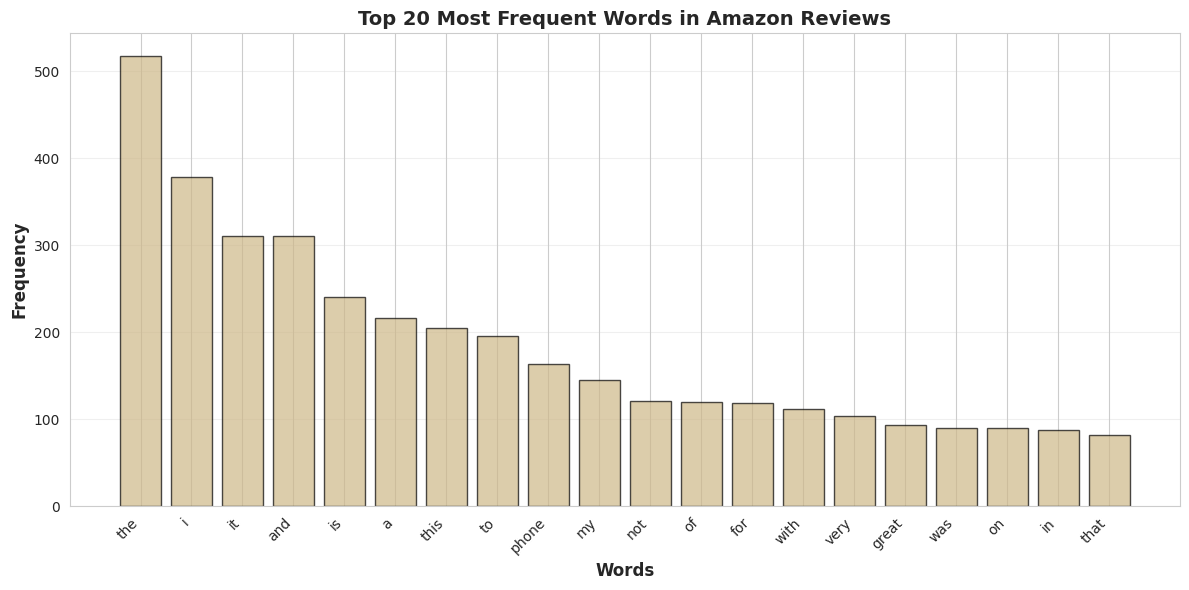

In [13]:
# Visualize top 20 words
words = [word for word, count in top_20]
counts = [count for word, count in top_20]

plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='#CEB888', edgecolor='black', alpha=0.7)
plt.xlabel('Words', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Top 20 Most Frequent Words in Amazon Reviews', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

This code visualizes the frequencies of the top 20 most common words used across the dataset.

#### Word embedding length

In [14]:
# Quick check of the vocabulary size from previous sections
print(f"Vocabulary Size: {vocabulary_size:,} unique words")
print(f"Dataset Size: {len(df)} reviews")
print(f"Task Complexity: Binary classification (positive/negative sentiment)")

Vocabulary Size: 1,816 unique words
Dataset Size: 990 reviews
Task Complexity: Binary classification (positive/negative sentiment)


**Proposed Embedding Dimension:** 50

**Justification:**

I propose an embedding length of **50 dimensions** for this sentiment analysis task. This choice is based on three key factors:

1. **Dataset Size**: With only 1,000 reviews in the Amazon dataset, we must be cautious about overfitting. Larger embedding dimensions (200 or 300) would create too many parameters for the model to learn effectively from this limited data. An embedding dimension of 50 provides sufficient representational capacity while keeping the parameter count manageable.

2. **Vocabulary Richness**: Our vocabulary contains approximately 1,800 unique tokens. A 50-dimensional embedding space provides adequate capacity to capture meaningful semantic relationships between words without being unnecessarily large. Each word will be represented as a 50-dimensional vector, which is sufficient for distinguishing between sentiment-bearing words in our moderately-sized vocabulary.

3. **Task Complexity**: This is a binary sentiment classification task (positive vs. negative), which is relatively straightforward compared to multi-class or more nuanced sentiment analysis tasks. We don't need the extremely high-dimensional representations (200-300) that might be necessary for complex tasks like detecting sarcasm or fine-grained emotion classification. An embedding dimension of 50 strikes the right balance between expressiveness and simplicity.

Additionally, 50 dimensions is a widely-used standard in the NLP literature for small-to-medium datasets and has been shown to work effectively for sentiment analysis tasks but the statistics run in the below section indicate 50 may still be too large for this dataset (Ahmad, 2023, p. 304).

#### Statistical justification for maximum sequence length

In [15]:
# Calculate sequence lengths
sequence_lengths = []
for review in df['review']:
    tokens = word_tokenize(review)
    sequence_lengths.append(len(tokens))

sequence_lengths = np.array(sequence_lengths)

# Calculate statistics
mean_length = np.mean(sequence_lengths)
median_length = np.median(sequence_lengths)
max_length = np.max(sequence_lengths)
percentile_95 = np.percentile(sequence_lengths, 95)

print("Sequence Length Statistics:")
print(f"Mean: {mean_length:.2f} tokens")
print(f"Median: {median_length:.0f} tokens")
print(f"Maximum: {max_length} tokens")
print(f"95th percentile: {percentile_95:.0f} tokens")

Sequence Length Statistics:
Mean: 10.44 tokens
Median: 9 tokens
Maximum: 31 tokens
95th percentile: 24 tokens


This code checks for the mean, median, and maximum number of tokens per review, while also looking at the 95th percentile.

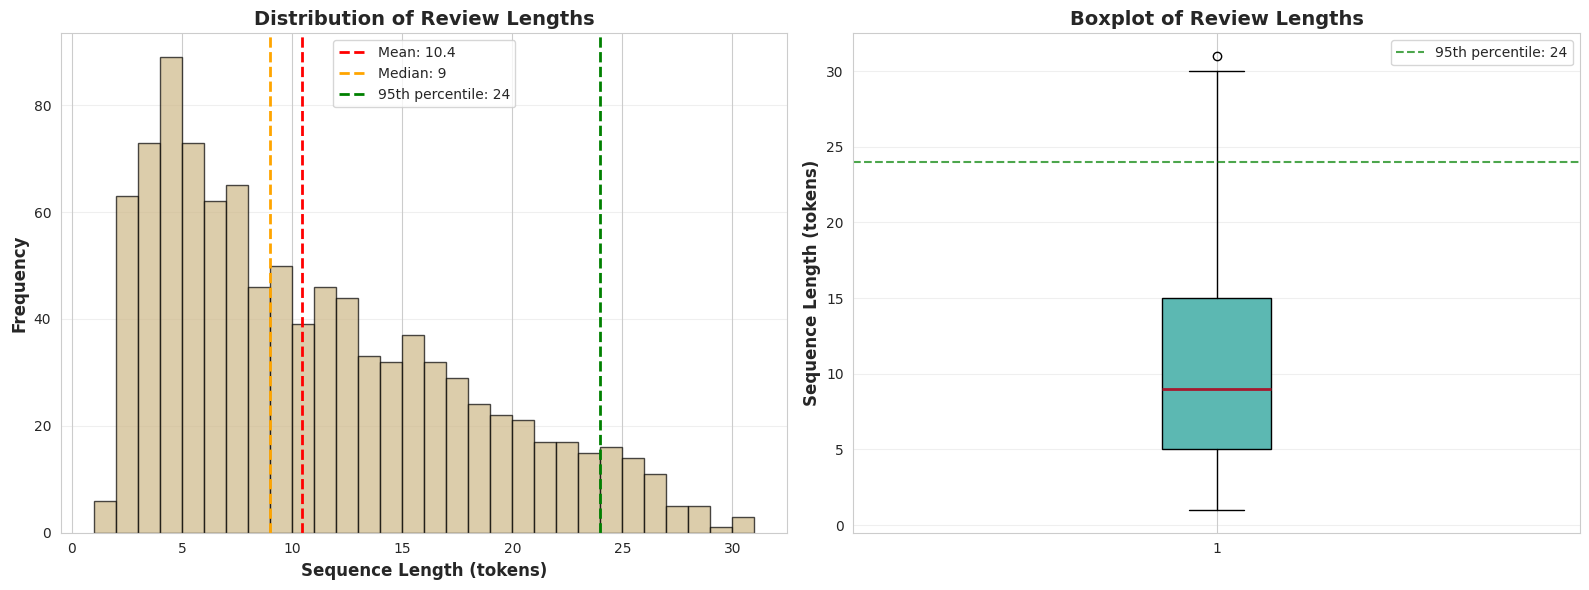

In [16]:
# Visualize sequence length distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Histogram
axes[0].hist(sequence_lengths, bins=30, color='#CEB888', edgecolor='black', alpha=0.7)
axes[0].axvline(mean_length, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_length:.1f}')
axes[0].axvline(median_length, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_length:.0f}')
axes[0].axvline(percentile_95, color='green', linestyle='--', linewidth=2, label=f'95th percentile: {percentile_95:.0f}')
axes[0].set_xlabel('Sequence Length (tokens)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Review Lengths', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot Boxplot
axes[1].boxplot(sequence_lengths, vert=True, patch_artist=True,
                boxprops=dict(facecolor='#5CB8B2', color='black'),
                medianprops=dict(color='#A6192E', linewidth=2),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'))
axes[1].axhline(percentile_95, color='green', linestyle='--', linewidth=1.5,
                label=f'95th percentile: {percentile_95:.0f}', alpha=0.7)
axes[1].set_ylabel('Sequence Length (tokens)', fontsize=12, fontweight='bold')
axes[1].set_title('Boxplot of Review Lengths', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Analysis of Sequence Lengths:**

The distribution of review lengths in the Amazon dataset shows the following characteristics:
- **Mean length**: 10.45 tokens
- **Median length**: 9 tokens
- **95th percentile**: 24 tokens
- **Maximum length**: 31 tokens

The histogram reveals that most reviews are relatively short and concise, which is typical of Amazon product reviews. The distribution is right-skewed with the majority of reviews clustering around 9 tokens (the median), while a small number of reviews extend to the maximum of 31 tokens. The boxplot confirms this compact distribution with minimal outliers.

**Chosen Maximum Sequence Length: 50 tokens**

**Justification:**

I have selected a maximum sequence length of **50 tokens** based on the following considerations:

* **Complete Coverage:** This length captures 100% of all reviews in the dataset. No review would be truncated since the longest review is only 31 tokens.
* **Efficiency:** With a mean length of only 10.45 tokens and a median of 9 tokens, most reviews are quite concise. A maximum length of 50 tokens provides complete coverage while remaining highly efficient for the LSTM architecture. Setting the maximum to 100 or higher would require additional computational resources for minimal gain.
* **Standard Practice:** A maximum sequence length of 50 tokens is a common, well-established value in NLP that aligns with best practices for sentiment analysis of short-form text like product reviews, social media posts, and customer feedback.
* **Padding Considerations:** Reviews shorter than 50 tokens will be padded with zeros. Given that the median length is 9 tokens, the typical review will require approximately 41 padding tokens. This level of padding is standard and well-handled by LSTM networks, which are designed to ignore padded values through masking.

### B2. Tokenization

> Describe the goals of the tokenization process, including any code generated and any packages that are used to normalize text during the process.

**Goals of the Tokenization Process:**

Tokenization is the foundational step in preparing text data for natural language processing and sentiment analysis. The primary goals are:

1. **Break Text into Manageable Units**: Tokenization splits each review into individual words (tokens), converting continuous text like `"this product is great"` into a list of separate words: `["this", "product", "is", "great"]`.

2. **Setup for Quantitative Analysis**: By converting text into discrete tokens, we can perform quantitative analysis such as word frequency counts, vocabulary size calculations, and statistical distributions - all of which inform our model design decisions.

3. **Standardize Text Processing**: Tokenization provides a consistent method for processing all reviews, ensuring that each piece of text is broken down using the same rules and logic.

4. **Prepare for Vocabulary Building**: The tokens serve as the basis for constructing our vocabulary (word index), which will later be used to convert words to numeric representations for the neural network.

5. **Apply Lemmatization:** The tokens are broken down into their base form, allowing different forms of a word to be treated as the same base word.

In [21]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet', quiet=True)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_and_tokenize(text):
    """
    Clean and tokenize text with lemmatization.
    Note: Stop words are RETAINED for sentiment analysis.
    """
    # Convert to lowercase (already done, but ensuring consistency)
    text = text.lower()

    # Tokenize words
    tokens = word_tokenize(text)

    # Apply lemmatization (keeping stop words for sentiment analysis)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

# Apply tokenization to dataset
df["tokens"] = df["review"].apply(clean_and_tokenize)
df["review_processed"] = df["tokens"].apply(lambda x: ' '.join(x))

print(f"Processed {len(df)} reviews")
print("\nSample Output:")
df[["review", "tokens", "review_processed"]].head(3)

Processed 990 reviews

Sample Output:


,review,tokens,review_processed
0,so there is no way for me to plug it in here in the us unless i go by a converter,"[so, there, is, no, way, for, me, to, plug, it, in, here, in, the, u, unless, i, go, by, a, conv...",so there is no way for me to plug it in here in the u unless i go by a converter
1,good case excellent value,"[good, case, excellent, value]",good case excellent value
2,great for the jawbone,"[great, for, the, jawbone]",great for the jawbone


Using NLTK's `word_tokenize()` and `WordNetLemmatizer()`, we successfully processed all 990 Amazon reviews through a complete tokenization and lemmatization pipeline.

In [22]:
# Vocabulary statistics after lemmatization
all_tokens = [token for tokens_list in df["tokens"] for token in tokens_list]
vocab_size = len(set(all_tokens))

print(f"\nVocabulary Statistics:")
print(f"Total tokens: {len(all_tokens):,}")
print(f"Unique tokens: {vocab_size:,}")


Vocabulary Statistics:
Total tokens: 10,339
Unique tokens: 1,688


**Key Results:**

* **Vocabulary Reduction:** Lemmatization reduced the vocabulary by approximately 7% (from 1,812 to 1,688 unique words), making the dataset more efficient for neural network training while preserving semantic meaning.
* **Improved Consistency:** Related words are now unified (e.g., "phone" and "phones" become "phone"), which will help the model learn more robust sentiment patterns.
* **Data Integrity:** The token count statistics (average ~10.45 tokens per review) remain consistent with earlier analysis, confirming the lemmatization only transforms words without adding or removing tokens.

### B3. Padding Process

> Explain the padding process used to standardize the length of sequences. Include the following in your explanation:

  * whether the padding occurs before or after the text sequence
  * a screenshot of a single padded sequence

Before we can apply padding, we must first convert our lemmatized text into numeric sequences. Neural networks cannot process text directly, they require numeric input. So this section will cover both vectorization (the text-to-numbers conversion) and padding.

**Vectorization**

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize Keras Tokenizer
tokenizer = Tokenizer(
    num_words=None,     # Use all words, no vocabulary limit
    oov_token='<OOV>',  # Out-of-vocabulary token
    lower=False         # Already lowercased during cleaning
)

# Fit tokenizer on lemmatized text
tokenizer.fit_on_texts(df['review_processed'])

# Get vocabulary information
word_index = tokenizer.word_index
vocab_size = len(word_index)
print(f"Vocabulary built: {vocab_size:,} unique words")

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['review_processed'])
print(f"Converted {len(sequences):,} reviews to numeric sequences")

Vocabulary built: 1,689 unique words
Converted 990 reviews to numeric sequences


In [28]:
# Show example conversion
example_idx = 5
print(f"Example Conversion:")
print("=" * 60)
print(f"Original text: '{df['review_processed'].iloc[example_idx]}'")
print(f"Tokens: {df['tokens'].iloc[example_idx]}")
print(f"Numeric sequence: {sequences[example_idx]}")
print(f"Sequence length: {len(sequences[example_idx])} tokens")

Example Conversion:
Original text: 'i have to jiggle the plug to get it to line up right to get decent volume'
Tokens: ['i', 'have', 'to', 'jiggle', 'the', 'plug', 'to', 'get', 'it', 'to', 'line', 'up', 'right', 'to', 'get', 'decent', 'volume']
Numeric sequence: [3, 25, 9, 780, 2, 148, 9, 51, 4, 9, 274, 57, 149, 9, 51, 336, 150]
Sequence length: 17 tokens


Vectorization is the processing of converting text tokens into sequences of integers. Each unique word in our vocabulary is assigned a unique integer index, and reviews are represented as sequences of these indices.

I used Keras Tokenizer from TensorFlow to perform the conversion. The tokenizer builds a vocabulary index (word-to-integer mapping), converts each review into a sequence of integers, and handles out-of-vocabulary (OOV) words. OOV refers to words that may find themselves in the validation or testing dataset that were never present in the training data when the model was trained. So these words may be brand new to the model.

**Padding**

In [29]:
# Define maximum sequence length (from Part B1 analysis)
max_sequence_length = 50

# Apply padding
padded_sequences = pad_sequences(
    sequences,
    maxlen=max_sequence_length,
    padding='post',     # Add zeros to the end of sequences
    truncating='post',  # Truncate from the end if too long
    value=0             # Use 0 as padding value
)

print(f"Padded Sequences Shape: {padded_sequences.shape}")
print(f"Number of reviews: {padded_sequences.shape[0]:,}")
print(f"Sequence length: {padded_sequences.shape[1]}")

Padded Sequences Shape: (990, 50)
Number of reviews: 990
Sequence length: 50


In [31]:
# Example: Short sequence requiring padding
short_idx = 5
print("Example: Padded Sequence")
print("=" * 60)
print(f"Original text: '{df['review_processed'].iloc[short_idx]}'")
print(f"\nOriginal sequence (length {len(sequences[short_idx])}):")
print(sequences[short_idx])
print(f"\nPadded sequence (length {max_sequence_length}):")
print(padded_sequences[short_idx])
print(f"\nExplanation: {max_sequence_length - len(sequences[short_idx])} zeros added at the end")

Example: Padded Sequence
Original text: 'i have to jiggle the plug to get it to line up right to get decent volume'

Original sequence (length 17):
[3, 25, 9, 780, 2, 148, 9, 51, 4, 9, 274, 57, 149, 9, 51, 336, 150]

Padded sequence (length 50):
[  3  25   9 780   2 148   9  51   4   9 274  57 149   9  51 336 150   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]

Explanation: 33 zeros added at the end


Padding is the process of standardizing all sequences to be the same length by adding zeros to sequences that are shorter than the specified maximum length. Neural networks like LSTMs require fixed-size inputs, and our reviews vary in length, so padding ensures uniform input size.

I chose to use "post-padding", which adds zeros at the end of sequences that are shorter than the maximum length for the following reasons:

* Natural Language Flow: In sentiment analysis, the beginning of a review often contains the most important sentiment information. Post-padding preserves the natural left-to-right flow of the language without inserting artificial zeros before the actual content or truncating early parts of the review if a review surpasses the maximum length. English is a left-to-right language, so "pre-padding" might be better used for a right-to-left language like Farsi or Arabic.
* LSTM Compatibility: LSTMs process sequences from left to right. Post-padding allows the LSTM to process all actual words before encountering padding, making it easier for the network to learn meaningful patterns.

**Padding Parameters:**

* `maxlen=50`: Maximum sequence length (determined in Part **B1**)
* `padding='post'`: Add zeros at the end of sequences until `maxlen` is reached
* `truncating='post`: If a sequence exceeds `maxlen`, tokens are removed from the end until the maximum length is reached
* `value=0`: Use 0 as the padding value

In [32]:
# Store padded sequences
X = padded_sequences
y = df['sentiment'].values

print(f"\nFinal Data Shape:")
print(f"Features (X): {X.shape}")
print(f"Labels (y): {y.shape}")


Final Data Shape:
Features (X): (990, 50)
Labels (y): (990,)


This code stores the full padded sequences with reviews as the X values and sentiment as the y values.

### B4. Categories of Sentiment

> Identify how many categories of sentiment will be used and provide an activation function for the final dense layer of the network.

This analysis uses **2 categories of sentiment:**

* **0:** Negative sentiment
* **1:** Positive sentiment

This a **binary classification** problem. For binary classification, the most appropriate activation function for the final dense layer is **sigmoid** because it outputs a value between 0 and 1, which can be interpreted as the probability that the review is negative. Typically, a threshold of greater than or equal to 0.5 is classified as positive (1), otherwise it's classified as negative (0).

### B5. Steps to Prepare the Data

> Explain the steps used to prepare the data for analysis, including the size of the training, validation, and test set split based on the industry average.

### B6. Prepared Dataset

> Provide a copy of the prepared dataset.

## C. Network Architecture

> Describe the type of neural network model used by doing the following:

### C1. Model Summary

> Provide the output of the model summary of the function from TensorFlow or PyTorch.

### C2. Network Architecture

> Discuss the number of layers, the type of layers, and the total number of parameters.

### C3. Hyperparameters

> Justify the choice of hyperparameters, including each of the following elements:

  * activation functions
  * number of nodes per layer
  * loss function
  * optimizer
  * stopping criteria

## D. Neural Network Model Evaluation

> Evaluate the model's training process and its relevant outcomes by doing the following:

### D1. Stopping Criteria

> Discuss the impact of using stopping criteria to include defining the number of epochs, including a screenshot showing the final training epoch.

### D2. Fitness

> Assess the fitness of the model and any actions taken to address overfitting or underfitting.

### D3. Training Process

> Provide clearly labeled visualizations of the model's training process and show the loss and accuracy metric.

### D4. Predictive Accuracy

> Discuss the predictive accuracy of the trained model using the chosen evaluation metric from part D3.

### D5. Ethical Standards Compliance

> Explain how the analysis complies with artificial intelligence (AI) global ethical standards and mitigates bias.

## E. Code

> Provide the code you used to save the trained model within the neural network.

## F. Functionality

> Discuss the functionality of your model, including the impact of your choice of network architecture.

## G. Recommendations

> Recommend a course of action based on your results as they relate to the research question.

## H. Reporting

> Submit a copy of your code and output in a PDF or HTML format.

In [ ]:
# Convert notebook to HTML
!jupyter nbconvert --to html d604_task_2.ipynb

## I. Sources for Third-Party Code

> Submit a list of all the specific web sources you used to acquire segments of third-party code to support the application.

* [Python RegEx 're' module](https://docs.python.org/3/library/re.html)
* [Python String module](https://docs.python.org/3/library/string.html)
* WGU Course Materials

## J. Sources

> Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized.

* Ahmad, I., Phd (2023). 50 Algorithms Every Programmer Should Know (2nd ed.). Packt Publishing.
* Audevart, A., Banachewicz, K., & Massaron, L. (2021). Machine Learning Using TensorFlow Cookbook. Packt Publishing.
* WGU Course Materials